<a href="https://www.kaggle.com/code/daneshselwal/bhumi-drishti-training?scriptVersionId=252176713" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Cell 1: Install HuggingFace Transformers, Datasets, and Torch (if not installed)
!pip install --quiet torch torchvision
!pip install --quiet transformers datasets timm
!pip install --quiet huggingface_hub --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's de

In [2]:
# Cell 2: Imports and Device Setup

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
from torchvision import transforms
import pandas as pd
import os

# Check device (should be CUDA on Kaggle GPU notebook)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-07-24 00:43:11.841475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753317792.194269      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753317792.294493      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [3]:
# Cell 3: List all .tif images and their labels from EuroSATallBands

import glob

# Path to EuroSATallBands (Change this if your path is different)
BANDS_PATH = "/kaggle/input/eurosat-dataset/EuroSATallBands"

class_names = sorted(os.listdir(BANDS_PATH))
data = []

for class_name in class_names:
    class_folder = os.path.join(BANDS_PATH, class_name)
    tiffs = glob.glob(os.path.join(class_folder, "*.tif"))
    for tif in tiffs:
        data.append({"image_path": tif, "label": class_name})

df = pd.DataFrame(data)
print(df.head())
print(f"Total samples: {len(df)}")
print(f"Classes: {df['label'].unique()}")

                                          image_path       label
0  /kaggle/input/eurosat-dataset/EuroSATallBands/...  AnnualCrop
1  /kaggle/input/eurosat-dataset/EuroSATallBands/...  AnnualCrop
2  /kaggle/input/eurosat-dataset/EuroSATallBands/...  AnnualCrop
3  /kaggle/input/eurosat-dataset/EuroSATallBands/...  AnnualCrop
4  /kaggle/input/eurosat-dataset/EuroSATallBands/...  AnnualCrop
Total samples: 27597
Classes: ['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [4]:
# Cell 4: Encode labels and split dataframe

from sklearn.model_selection import train_test_split

# Create label mapping
label2id = {name: i for i, name in enumerate(sorted(df['label'].unique()))}
id2label = {v: k for k, v in label2id.items()}

df['label_id'] = df['label'].map(label2id)

# Stratified split
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label_id'])

print(f"Train: {len(df_train)}\nVal: {len(df_val)}\nTest: {len(df_test)}")
print("Label mapping:", label2id)

Train: 22077
Val: 2760
Test: 2760
Label mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [5]:
# Cell 5: Install rasterio for reading .tif images
!pip install --quiet rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.7 MB/s eta 0:00:00:00:0100:01


In [6]:
# Cell 6 (Combined): EuroSAT prithvi-6-band Dataset definition, load test, one sample

import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np

class EuroSATPrithvi6BandDataset(Dataset):
    def __init__(self, df, label2id, transform=None):
        self.df = df.reset_index(drop=True)
        self.label2id = label2id
        self.transform = transform
        # Blue, Green, Red, Narrow NIR, SWIR1, SWIR2 = [1,2,3,8,10,11]
        self.band_indices = [1, 2, 3, 8, 10, 11]  

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        image_path = record['image_path']
        label = self.label2id[record['label']]

        with rasterio.open(image_path) as src:
            img = src.read()  # (13, H, W)
            img = img[self.band_indices, :, :]  # select only 6 needed bands
            img = img.astype(np.float32)
            img = img / img.max() if img.max() > 1 else img   # normalize to [0,1]

        if self.transform:
            img = self.transform(torch.from_numpy(img))

        return {
            "pixel_values": torch.from_numpy(img).float(),  # (6, H, W)
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Instantiate for train/val/test (transforms will be handled later if needed)
train_dataset = EuroSATPrithvi6BandDataset(df_train, label2id)
val_dataset   = EuroSATPrithvi6BandDataset(df_val, label2id)
test_dataset  = EuroSATPrithvi6BandDataset(df_test, label2id)

# Print shapes and label for a sample
sample = train_dataset[0]
print("Shape of 6-band img:", sample['pixel_values'].shape)
print("Label (numeric):", sample['labels'])

Shape of 6-band img: torch.Size([6, 64, 64])
Label (numeric): tensor(4)


In [7]:
import sys
import importlib.util
import torch
import json
import os

MODEL_DIR = "/kaggle/input/models"

# Import model code
spec = importlib.util.spec_from_file_location("prithvi_mae", os.path.join(MODEL_DIR, "prithvi_mae.py"))
prithvi_mae = importlib.util.module_from_spec(spec)
sys.modules["prithvi_mae"] = prithvi_mae
spec.loader.exec_module(prithvi_mae)

# Load config.json
with open(os.path.join(MODEL_DIR, "config.json")) as f:
    config = json.load(f)

print("Config loaded:", config['pretrained_cfg'])

# Instantiate the model using only pretrained_cfg (not the outer dict)
mae_model = prithvi_mae.PrithviMAE(**config['pretrained_cfg'])
print("Instantiated PrithviMAE.")

# Load weights
ckpt = torch.load(os.path.join(MODEL_DIR, "Prithvi_EO_V2_300M.pt"), map_location="cpu")
mae_model.load_state_dict(ckpt, strict=False)
print("Loaded pretrained weights.")

Config loaded: {'img_size': 224, 'num_frames': 4, 'patch_size': [1, 16, 16], 'in_chans': 6, 'embed_dim': 1024, 'depth': 24, 'num_heads': 16, 'decoder_embed_dim': 512, 'decoder_depth': 8, 'decoder_num_heads': 16, 'mlp_ratio': 4, 'coords_encoding': [], 'coords_scale_learn': False, 'mask_ratio': 0.75, 'norm_pix_loss': False, 'bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07'], 'mean': [1087.0, 1342.0, 1433.0, 2734.0, 1958.0, 1363.0], 'std': [2248.0, 2179.0, 2178.0, 1850.0, 1242.0, 1049.0], 'origin_url': 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M', 'paper_ids': 'arXiv:X.X'}
Instantiated PrithviMAE.
Loaded pretrained weights.


In [8]:
# Cell 8: Define a Prithvi EuroSAT classifier model

import torch.nn as nn
import torch

class PrithviEuroSATClassifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes):
        super().__init__()
        self.encoder = pretrained_mae.encoder  # Use the encoder for features
        self.norm = pretrained_mae.encoder.norm  # Final norm layer after encoder
        self.cls_head = nn.Linear(self.encoder.embed_dim, num_classes)
    
    def forward(self, x):
        # The encoder expects shape [B, C, T, H, W].
        # We use T=1 (single temporal step) for EuroSAT images:
        if len(x.shape) == 4:
            # Add time dimension (T=1)
            x = x.unsqueeze(2)
        features = self.encoder(x)[0]  # [B, num_tokens+1, embed_dim], first is CLS token
        cls_tok = features[:, 0]       # CLS token ([B, embed_dim])
        logits = self.cls_head(cls_tok)
        return logits

# Instantiate your classifier
NUM_CLASSES = len(label2id)
model = PrithviEuroSATClassifier(mae_model, num_classes=NUM_CLASSES)
model = model.to(device)

print("EuroSAT classifier ready:", model)

EuroSAT classifier ready: PrithviEuroSATClassifier(
  (encoder): PrithviViT(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 1024, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False

In [9]:
# Cell 9: DataLoaders, Loss, Optimizer

from torch.utils.data import DataLoader

BATCH_SIZE = 512  # Adjust as Kaggle GPU memory allows, 16 or 8 is usually safe
NUM_WORKERS = 8  # You can try 4 for faster I/O if RAM allows

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

print("DataLoaders, Loss, and Optimizer created.")

DataLoaders, Loss, and Optimizer created.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
import types

def patched_forward(self, x, temporal_coords=None, location_coords=None, mask_ratio=0.75):
    if len(x.shape) == 4 and self.patch_embed.input_size[0] == 1:
        x = x.unsqueeze(2)
    sample_shape = x.shape[-3:]
    x = self.patch_embed(x)
    pos_embed = self.interpolate_pos_encoding(sample_shape)
    pos_embed = pos_embed.to(x.device)  # <--- Core fix: move pos_embed to correct device!
    x = x + pos_embed[:, 1:, :]
    if self.temporal_encoding and temporal_coords is not None:
        num_tokens_per_frame = x.shape[1] // self.num_frames
        temporal_encoding = self.temporal_embed_enc(temporal_coords, num_tokens_per_frame)
        x = x + temporal_encoding
    if self.location_encoding and location_coords is not None:
        location_encoding = self.location_embed_enc(location_coords)
        x = x + location_encoding
    x, mask, ids_restore = self.random_masking(x, mask_ratio)
    cls_token = self.cls_token + pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    for block in self.blocks:
        x = block(x)
    x = self.norm(x)
    return x, mask, ids_restore

# Patch your model's encoder:
model.encoder.forward = types.MethodType(patched_forward, model.encoder)

Epoch 1 [Train]: 100%|██████████| 44/44 [01:36<00:00,  2.19s/it]


Epoch 1 | Train Loss: 1.6529 | Train Acc: 0.4025


Epoch 1 [Val]: 100%|██████████| 6/6 [00:17<00:00,  3.00s/it]


Epoch 1 | Val Loss: 1.0420 | Val Acc: 0.6123
Saved new best model.


Epoch 2 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 2 | Train Loss: 0.8556 | Train Acc: 0.6837


Epoch 2 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 2 | Val Loss: 0.7393 | Val Acc: 0.7417
Saved new best model.


Epoch 3 [Train]: 100%|██████████| 44/44 [01:27<00:00,  2.00s/it]


Epoch 3 | Train Loss: 0.6767 | Train Acc: 0.7571


Epoch 3 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 3 | Val Loss: 0.7314 | Val Acc: 0.7333


Epoch 4 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 4 | Train Loss: 0.5982 | Train Acc: 0.7918


Epoch 4 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 4 | Val Loss: 0.6903 | Val Acc: 0.7591
Saved new best model.


Epoch 5 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 5 | Train Loss: 0.5274 | Train Acc: 0.8186


Epoch 5 [Val]: 100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Epoch 5 | Val Loss: 0.4799 | Val Acc: 0.8254
Saved new best model.


Epoch 6 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 6 | Train Loss: 0.4515 | Train Acc: 0.8440


Epoch 6 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 6 | Val Loss: 0.4480 | Val Acc: 0.8417
Saved new best model.


Epoch 7 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 7 | Train Loss: 0.4398 | Train Acc: 0.8493


Epoch 7 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 7 | Val Loss: 0.4692 | Val Acc: 0.8377


Epoch 8 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 8 | Train Loss: 0.4128 | Train Acc: 0.8575


Epoch 8 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 8 | Val Loss: 0.4420 | Val Acc: 0.8482
Saved new best model.


Epoch 9 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 9 | Train Loss: 0.3899 | Train Acc: 0.8662


Epoch 9 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 9 | Val Loss: 0.5415 | Val Acc: 0.8109


Epoch 10 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 10 | Train Loss: 0.3525 | Train Acc: 0.8787


Epoch 10 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 10 | Val Loss: 0.3454 | Val Acc: 0.8826
Saved new best model.


Epoch 11 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 11 | Train Loss: 0.3262 | Train Acc: 0.8869


Epoch 11 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 11 | Val Loss: 0.3673 | Val Acc: 0.8797


Epoch 12 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 12 | Train Loss: 0.3028 | Train Acc: 0.8976


Epoch 12 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 12 | Val Loss: 0.3494 | Val Acc: 0.8804


Epoch 13 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 13 | Train Loss: 0.2905 | Train Acc: 0.9011


Epoch 13 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 13 | Val Loss: 0.3651 | Val Acc: 0.8812


Epoch 14 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 14 | Train Loss: 0.2993 | Train Acc: 0.8962


Epoch 14 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 14 | Val Loss: 0.2983 | Val Acc: 0.8971
Saved new best model.


Epoch 15 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 15 | Train Loss: 0.2701 | Train Acc: 0.9067


Epoch 15 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 15 | Val Loss: 0.3773 | Val Acc: 0.8746


Epoch 16 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 16 | Train Loss: 0.2717 | Train Acc: 0.9066


Epoch 16 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 16 | Val Loss: 0.3292 | Val Acc: 0.8913


Epoch 17 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 17 | Train Loss: 0.2509 | Train Acc: 0.9149


Epoch 17 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 17 | Val Loss: 0.3839 | Val Acc: 0.8692


Epoch 18 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 18 | Train Loss: 0.2553 | Train Acc: 0.9135


Epoch 18 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 18 | Val Loss: 0.3036 | Val Acc: 0.8935


Epoch 19 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 19 | Train Loss: 0.2449 | Train Acc: 0.9176


Epoch 19 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 19 | Val Loss: 0.4059 | Val Acc: 0.8667


Epoch 20 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 20 | Train Loss: 0.2410 | Train Acc: 0.9177


Epoch 20 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 20 | Val Loss: 0.3144 | Val Acc: 0.8917


Epoch 21 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 21 | Train Loss: 0.2245 | Train Acc: 0.9238


Epoch 21 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 21 | Val Loss: 0.2768 | Val Acc: 0.9159
Saved new best model.


Epoch 22 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 22 | Train Loss: 0.2020 | Train Acc: 0.9317


Epoch 22 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 22 | Val Loss: 0.3470 | Val Acc: 0.8837


Epoch 23 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 23 | Train Loss: 0.2340 | Train Acc: 0.9210


Epoch 23 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 23 | Val Loss: 0.2695 | Val Acc: 0.9040


Epoch 24 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 24 | Train Loss: 0.2100 | Train Acc: 0.9290


Epoch 24 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 24 | Val Loss: 0.3179 | Val Acc: 0.8975


Epoch 25 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 25 | Train Loss: 0.1945 | Train Acc: 0.9349


Epoch 25 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 25 | Val Loss: 0.2400 | Val Acc: 0.9163
Saved new best model.


Epoch 26 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 26 | Train Loss: 0.1841 | Train Acc: 0.9384


Epoch 26 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 26 | Val Loss: 0.2721 | Val Acc: 0.9105


Epoch 27 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 27 | Train Loss: 0.1906 | Train Acc: 0.9366


Epoch 27 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 27 | Val Loss: 0.3146 | Val Acc: 0.8989


Epoch 28 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 28 | Train Loss: 0.1835 | Train Acc: 0.9368


Epoch 28 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 28 | Val Loss: 0.2857 | Val Acc: 0.9109


Epoch 29 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 29 | Train Loss: 0.1917 | Train Acc: 0.9348


Epoch 29 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 29 | Val Loss: 0.2666 | Val Acc: 0.9188
Saved new best model.


Epoch 30 [Train]: 100%|██████████| 44/44 [01:28<00:00,  2.00s/it]


Epoch 30 | Train Loss: 0.1687 | Train Acc: 0.9432


Epoch 30 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 30 | Val Loss: 0.2681 | Val Acc: 0.9047


Epoch 31 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 31 | Train Loss: 0.1760 | Train Acc: 0.9401


Epoch 31 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 31 | Val Loss: 0.2712 | Val Acc: 0.9138


Epoch 32 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 32 | Train Loss: 0.1733 | Train Acc: 0.9408


Epoch 32 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 32 | Val Loss: 0.2517 | Val Acc: 0.9203
Saved new best model.


Epoch 33 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 33 | Train Loss: 0.1794 | Train Acc: 0.9383


Epoch 33 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 33 | Val Loss: 0.2580 | Val Acc: 0.9112


Epoch 34 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 34 | Train Loss: 0.1524 | Train Acc: 0.9482


Epoch 34 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 34 | Val Loss: 0.2758 | Val Acc: 0.9080


Epoch 35 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 35 | Train Loss: 0.1603 | Train Acc: 0.9453


Epoch 35 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 35 | Val Loss: 0.2538 | Val Acc: 0.9145


Epoch 36 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 36 | Train Loss: 0.1675 | Train Acc: 0.9434


Epoch 36 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 36 | Val Loss: 0.2936 | Val Acc: 0.9047


Epoch 37 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 37 | Train Loss: 0.1750 | Train Acc: 0.9408


Epoch 37 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 37 | Val Loss: 0.3314 | Val Acc: 0.8978


Epoch 38 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 38 | Train Loss: 0.1707 | Train Acc: 0.9435


Epoch 38 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 38 | Val Loss: 0.2609 | Val Acc: 0.9174


Epoch 39 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 39 | Train Loss: 0.1570 | Train Acc: 0.9478


Epoch 39 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 39 | Val Loss: 0.2755 | Val Acc: 0.9130


Epoch 40 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 40 | Train Loss: 0.1621 | Train Acc: 0.9455


Epoch 40 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 40 | Val Loss: 0.2923 | Val Acc: 0.9076


Epoch 41 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 41 | Train Loss: 0.1512 | Train Acc: 0.9490


Epoch 41 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 41 | Val Loss: 0.2622 | Val Acc: 0.9130


Epoch 42 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 42 | Train Loss: 0.1379 | Train Acc: 0.9538


Epoch 42 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 42 | Val Loss: 0.2553 | Val Acc: 0.9214
Saved new best model.


Epoch 43 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 43 | Train Loss: 0.1458 | Train Acc: 0.9510


Epoch 43 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 43 | Val Loss: 0.2224 | Val Acc: 0.9246
Saved new best model.


Epoch 44 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 44 | Train Loss: 0.1420 | Train Acc: 0.9516


Epoch 44 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 44 | Val Loss: 0.2875 | Val Acc: 0.9170


Epoch 45 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 45 | Train Loss: 0.1354 | Train Acc: 0.9542


Epoch 45 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 45 | Val Loss: 0.2400 | Val Acc: 0.9246


Epoch 46 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 46 | Train Loss: 0.1406 | Train Acc: 0.9536


Epoch 46 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 46 | Val Loss: 0.2520 | Val Acc: 0.9188


Epoch 47 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 47 | Train Loss: 0.1297 | Train Acc: 0.9552


Epoch 47 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 47 | Val Loss: 0.3028 | Val Acc: 0.9051


Epoch 48 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 48 | Train Loss: 0.1425 | Train Acc: 0.9529


Epoch 48 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 48 | Val Loss: 0.2678 | Val Acc: 0.9188


Epoch 49 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 49 | Train Loss: 0.1411 | Train Acc: 0.9535


Epoch 49 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 49 | Val Loss: 0.2329 | Val Acc: 0.9225


Epoch 50 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 50 | Train Loss: 0.1245 | Train Acc: 0.9572


Epoch 50 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Epoch 50 | Val Loss: 0.2621 | Val Acc: 0.9170


Epoch 51 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 51 | Train Loss: 0.1199 | Train Acc: 0.9607


Epoch 51 [Val]: 100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Epoch 51 | Val Loss: 0.3261 | Val Acc: 0.9040


Epoch 52 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 52 | Train Loss: 0.1339 | Train Acc: 0.9544


Epoch 52 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 52 | Val Loss: 0.2914 | Val Acc: 0.9130


Epoch 53 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 53 | Train Loss: 0.1360 | Train Acc: 0.9543


Epoch 53 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 53 | Val Loss: 0.3011 | Val Acc: 0.9091


Epoch 54 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 54 | Train Loss: 0.1329 | Train Acc: 0.9548


Epoch 54 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 54 | Val Loss: 0.2820 | Val Acc: 0.9101


Epoch 55 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 55 | Train Loss: 0.1256 | Train Acc: 0.9585


Epoch 55 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 55 | Val Loss: 0.2852 | Val Acc: 0.9091


Epoch 56 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 56 | Train Loss: 0.1081 | Train Acc: 0.9638


Epoch 56 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 56 | Val Loss: 0.2335 | Val Acc: 0.9290
Saved new best model.


Epoch 57 [Train]: 100%|██████████| 44/44 [01:27<00:00,  2.00s/it]


Epoch 57 | Train Loss: 0.1185 | Train Acc: 0.9613


Epoch 57 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 57 | Val Loss: 0.2190 | Val Acc: 0.9290


Epoch 58 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 58 | Train Loss: 0.1125 | Train Acc: 0.9621


Epoch 58 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 58 | Val Loss: 0.2711 | Val Acc: 0.9167


Epoch 59 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 59 | Train Loss: 0.1146 | Train Acc: 0.9628


Epoch 59 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 59 | Val Loss: 0.2293 | Val Acc: 0.9283


Epoch 60 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 60 | Train Loss: 0.1078 | Train Acc: 0.9633


Epoch 60 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 60 | Val Loss: 0.2678 | Val Acc: 0.9228


Epoch 61 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 61 | Train Loss: 0.1105 | Train Acc: 0.9643


Epoch 61 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 61 | Val Loss: 0.2725 | Val Acc: 0.9163


Epoch 62 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 62 | Train Loss: 0.1073 | Train Acc: 0.9646


Epoch 62 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 62 | Val Loss: 0.2622 | Val Acc: 0.9178


Epoch 63 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 63 | Train Loss: 0.1052 | Train Acc: 0.9654


Epoch 63 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 63 | Val Loss: 0.2652 | Val Acc: 0.9167


Epoch 64 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 64 | Train Loss: 0.1041 | Train Acc: 0.9649


Epoch 64 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 64 | Val Loss: 0.2861 | Val Acc: 0.9120


Epoch 65 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 65 | Train Loss: 0.1041 | Train Acc: 0.9649


Epoch 65 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 65 | Val Loss: 0.2402 | Val Acc: 0.9290


Epoch 66 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 66 | Train Loss: 0.0958 | Train Acc: 0.9686


Epoch 66 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 66 | Val Loss: 0.2942 | Val Acc: 0.9076


Epoch 67 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 67 | Train Loss: 0.1228 | Train Acc: 0.9602


Epoch 67 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 67 | Val Loss: 0.3084 | Val Acc: 0.9101


Epoch 68 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 68 | Train Loss: 0.1047 | Train Acc: 0.9652


Epoch 68 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 68 | Val Loss: 0.3187 | Val Acc: 0.8971


Epoch 69 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 69 | Train Loss: 0.1311 | Train Acc: 0.9554


Epoch 69 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 69 | Val Loss: 0.2766 | Val Acc: 0.9221


Epoch 70 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 70 | Train Loss: 0.1086 | Train Acc: 0.9634


Epoch 70 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 70 | Val Loss: 0.2799 | Val Acc: 0.9178


Epoch 71 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 71 | Train Loss: 0.0944 | Train Acc: 0.9685


Epoch 71 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 71 | Val Loss: 0.2330 | Val Acc: 0.9326
Saved new best model.


Epoch 72 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 72 | Train Loss: 0.1037 | Train Acc: 0.9661


Epoch 72 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 72 | Val Loss: 0.2580 | Val Acc: 0.9275


Epoch 73 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 73 | Train Loss: 0.0939 | Train Acc: 0.9697


Epoch 73 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 73 | Val Loss: 0.2389 | Val Acc: 0.9283


Epoch 74 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 74 | Train Loss: 0.0966 | Train Acc: 0.9688


Epoch 74 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 74 | Val Loss: 0.2447 | Val Acc: 0.9279


Epoch 75 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 75 | Train Loss: 0.0957 | Train Acc: 0.9689


Epoch 75 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 75 | Val Loss: 0.2869 | Val Acc: 0.9127


Epoch 76 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 76 | Train Loss: 0.0869 | Train Acc: 0.9716


Epoch 76 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Epoch 76 | Val Loss: 0.4789 | Val Acc: 0.8725


Epoch 77 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 77 | Train Loss: 0.1328 | Train Acc: 0.9558


Epoch 77 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 77 | Val Loss: 0.2848 | Val Acc: 0.9123


Epoch 78 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 78 | Train Loss: 0.0842 | Train Acc: 0.9722


Epoch 78 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 78 | Val Loss: 0.2266 | Val Acc: 0.9319


Epoch 79 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 79 | Train Loss: 0.0919 | Train Acc: 0.9695


Epoch 79 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 79 | Val Loss: 0.2665 | Val Acc: 0.9236


Epoch 80 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 80 | Train Loss: 0.1046 | Train Acc: 0.9652


Epoch 80 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 80 | Val Loss: 0.2958 | Val Acc: 0.9105


Epoch 81 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 81 | Train Loss: 0.1003 | Train Acc: 0.9675


Epoch 81 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 81 | Val Loss: 0.2388 | Val Acc: 0.9301


Epoch 82 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 82 | Train Loss: 0.0915 | Train Acc: 0.9701


Epoch 82 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 82 | Val Loss: 0.2541 | Val Acc: 0.9261


Epoch 83 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 83 | Train Loss: 0.0928 | Train Acc: 0.9697


Epoch 83 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 83 | Val Loss: 0.2467 | Val Acc: 0.9221


Epoch 84 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Epoch 84 | Train Loss: 0.0881 | Train Acc: 0.9702


Epoch 84 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 84 | Val Loss: 0.2283 | Val Acc: 0.9261


Epoch 85 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 85 | Train Loss: 0.0738 | Train Acc: 0.9763


Epoch 85 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 85 | Val Loss: 0.3795 | Val Acc: 0.8996


Epoch 86 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 86 | Train Loss: 0.0980 | Train Acc: 0.9680


Epoch 86 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 86 | Val Loss: 0.2770 | Val Acc: 0.9134


Epoch 87 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 87 | Train Loss: 0.0927 | Train Acc: 0.9705


Epoch 87 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 87 | Val Loss: 0.2367 | Val Acc: 0.9315


Epoch 88 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 88 | Train Loss: 0.0764 | Train Acc: 0.9751


Epoch 88 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 88 | Val Loss: 0.2375 | Val Acc: 0.9301


Epoch 89 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 89 | Train Loss: 0.0865 | Train Acc: 0.9711


Epoch 89 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 89 | Val Loss: 0.3146 | Val Acc: 0.9094


Epoch 90 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 90 | Train Loss: 0.0881 | Train Acc: 0.9715


Epoch 90 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 90 | Val Loss: 0.2740 | Val Acc: 0.9236


Epoch 91 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 91 | Train Loss: 0.0941 | Train Acc: 0.9682


Epoch 91 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 91 | Val Loss: 0.2773 | Val Acc: 0.9167


Epoch 92 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 92 | Train Loss: 0.0718 | Train Acc: 0.9777


Epoch 92 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Epoch 92 | Val Loss: 0.2687 | Val Acc: 0.9264


Epoch 93 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 93 | Train Loss: 0.0783 | Train Acc: 0.9736


Epoch 93 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Epoch 93 | Val Loss: 0.2548 | Val Acc: 0.9228


Epoch 94 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.98s/it]


Epoch 94 | Train Loss: 0.0803 | Train Acc: 0.9751


Epoch 94 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 94 | Val Loss: 0.2498 | Val Acc: 0.9315


Epoch 95 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 95 | Train Loss: 0.0825 | Train Acc: 0.9741


Epoch 95 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Epoch 95 | Val Loss: 0.2445 | Val Acc: 0.9315


Epoch 96 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 96 | Train Loss: 0.0669 | Train Acc: 0.9786


Epoch 96 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 96 | Val Loss: 0.2700 | Val Acc: 0.9264


Epoch 97 [Train]: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Epoch 97 | Train Loss: 0.0943 | Train Acc: 0.9683


Epoch 97 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 97 | Val Loss: 0.2364 | Val Acc: 0.9283


Epoch 98 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 98 | Train Loss: 0.0790 | Train Acc: 0.9738


Epoch 98 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 98 | Val Loss: 0.2395 | Val Acc: 0.9261


Epoch 99 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 99 | Train Loss: 0.0788 | Train Acc: 0.9733


Epoch 99 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Epoch 99 | Val Loss: 0.2441 | Val Acc: 0.9250


Epoch 100 [Train]: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Epoch 100 | Train Loss: 0.0815 | Train Acc: 0.9733


Epoch 100 [Val]: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Epoch 100 | Val Loss: 0.2698 | Val Acc: 0.9236
Training complete!


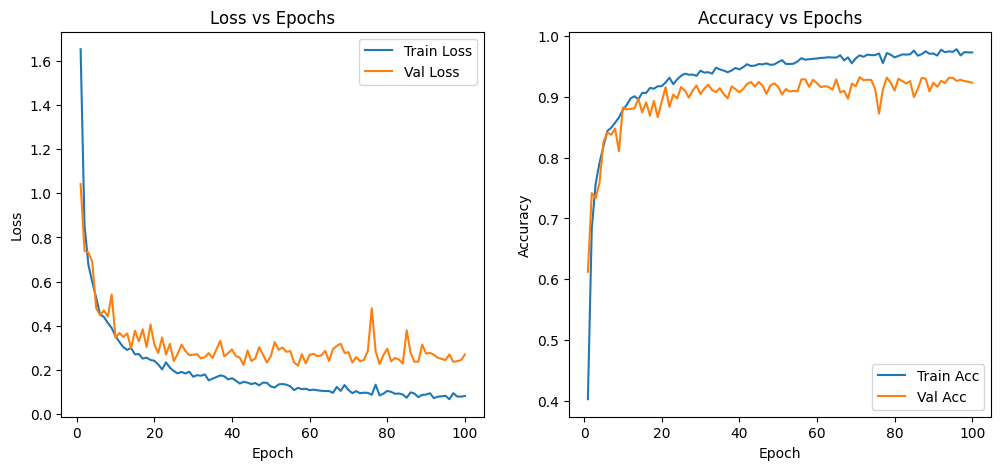

In [11]:
# Cell 10: Training/validation loop with metrics tracking and learning curves plot

from tqdm import tqdm
import matplotlib.pyplot as plt

NUM_EPOCHS = 100  # Set this >1 for meaningful curves!
best_val_acc = 0.0

# Store history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    train_loss, correct, total = 0., 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * pixel_values.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += pixel_values.size(0)
    avg_train_loss = train_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0., 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            val_loss += loss.item() * pixel_values.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += pixel_values.size(0)
    avg_val_loss = val_loss / total
    val_acc = correct / total
    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save history
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    # Save best model (optional)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "best_prithvi_eurosat.pt")
        best_val_acc = val_acc
        print("Saved new best model.")

print("Training complete!")

# Plot learning curves!
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

In [12]:
# Cell 11: Evaluate on the test set

from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Load the best model checkpoint (saved during validation)
model.load_state_dict(torch.load("best_prithvi_eurosat.pt"))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        logits = model(pixel_values)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += pixel_values.size(0)
test_acc = correct / total
print("Test accuracy:", test_acc)

Test: 100%|██████████| 6/6 [00:20<00:00,  3.44s/it]

Test accuracy: 0.9246376811594202


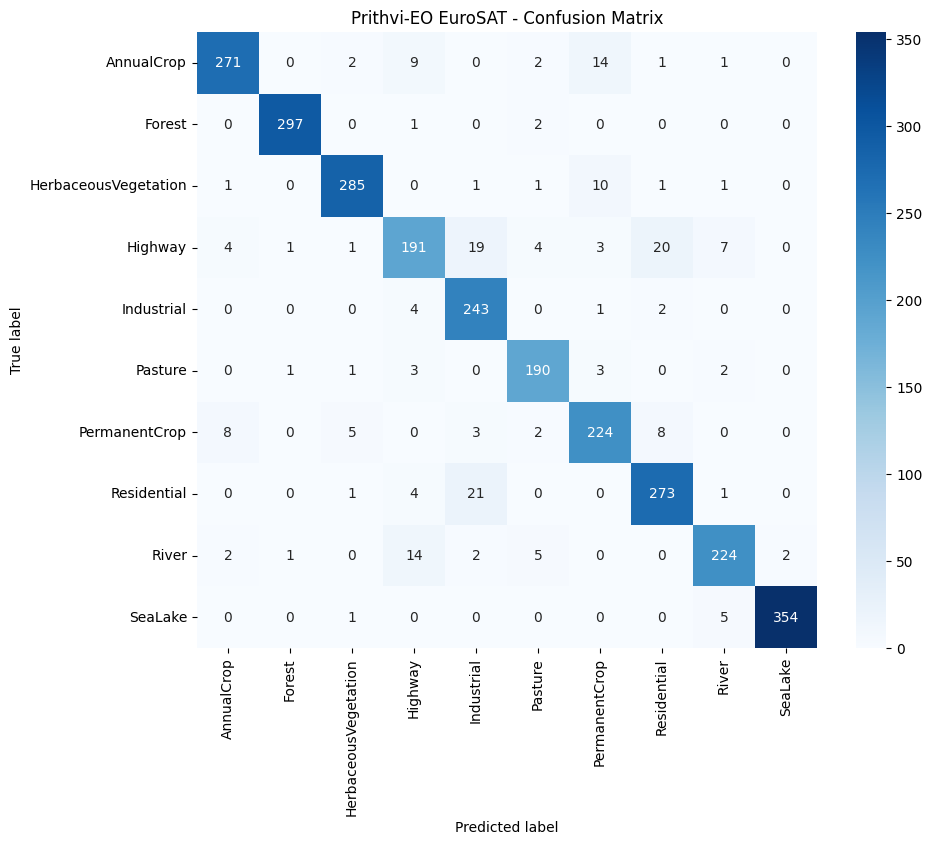

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=list(label2id.keys()), 
            yticklabels=list(label2id.keys()), cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Prithvi-EO EuroSAT - Confusion Matrix")
plt.show()

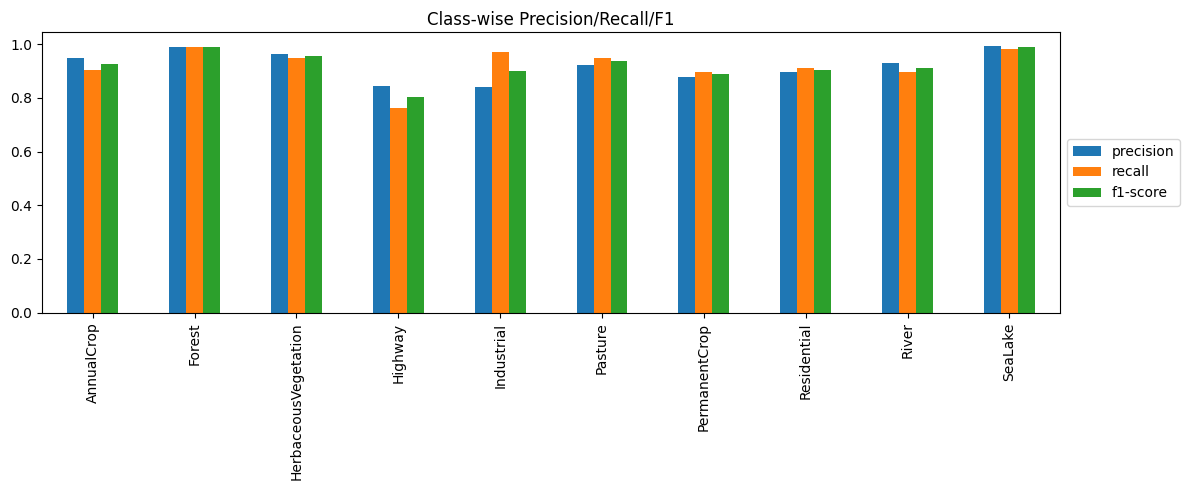

In [14]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(all_labels, all_preds, target_names=list(label2id.keys()), output_dict=True)
df_report = pd.DataFrame(report).T

ax = df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(
    kind='bar', figsize=(12,5)
)
plt.title("Class-wise Precision/Recall/F1")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

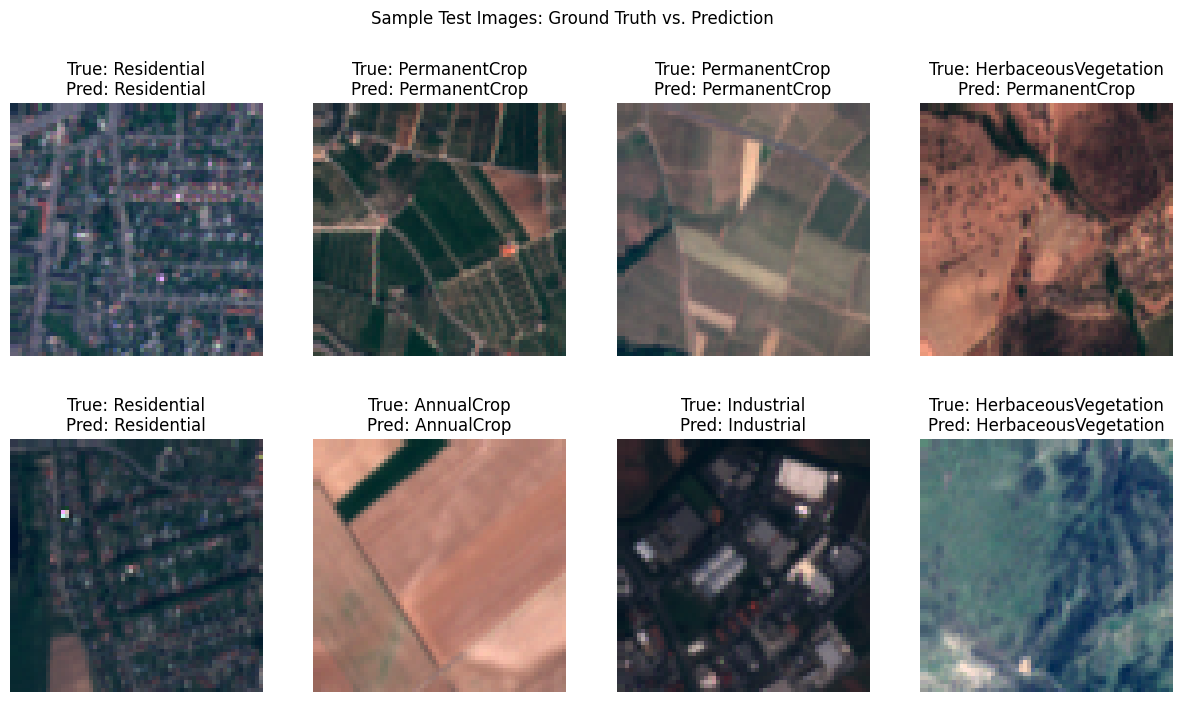

In [15]:
import random
import rasterio

idxs = random.sample(range(len(test_dataset)), 8)
plt.figure(figsize=(15,8))
for i, idx in enumerate(idxs):
    sample = test_dataset[idx]
    img = sample['pixel_values'].numpy()  # (6, 64, 64)
    # Convert to RGB for display (bands 2,3,4 ≈ G,R,B for Sentinel-2 convention)
    img_disp = img[[2,1,0],:,:]  # This may differ if your bands are ordered differently
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())  # Normalize to 0..1
    img_disp = np.transpose(img_disp, (1,2,0))
    pred = model(sample['pixel_values'].unsqueeze(0).to(device)).argmax(dim=1).item()
    plt.subplot(2,4,i+1)
    plt.imshow(img_disp)
    plt.title(f"True: {id2label[sample['labels'].item()]}\nPred: {id2label[pred]}")
    plt.axis('off')
plt.suptitle("Sample Test Images: Ground Truth vs. Prediction")
plt.show()

In [16]:
from IPython.display import FileLink

# First, ensure the file is saved in your working directory.
MODEL_FILENAME = "best_prithvi_eurosat.pt"

# Create a downloadable link
display(FileLink(MODEL_FILENAME))

/kaggle/working/best_prithvi_eurosat.pt